# Feature Extraction Demo

This notebook demonstrates the new feature extraction system for LLM-based jet classification.

**New Features:**
1. Config-based initialization
2. Modular feature extractors (basic, kinematic, concentration, full)
3. Auto-detection of required features from template placeholders
4. Feature-based prompt templates

**Goal:** Compare raw particle templates vs feature-based templates on a small sample.


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from vibe_jet_tagging import LLMClassifier
from vibe_jet_tagging.config import LLMConfig
from vibe_jet_tagging.feature_extractors import BasicExtractor, KinematicExtractor, FullExtractor
from sklearn.metrics import accuracy_score, roc_auc_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Data & Demo Feature Extractors


In [3]:
# Load dataset
data_path = Path.cwd().parent / 'data' / 'qg_jets.npz'
data = np.load(data_path)

X = data['X']
y = data['y']

# Use a small test set (10 jets for quick API testing)
n_test = 10
X_test = X[:n_test]
y_test = y[:n_test]

print(f"Loaded {n_test} test jets")
print(f"  Quark: {np.sum(y_test == 1)}")
print(f"  Gluon: {np.sum(y_test == 0)}")

# Demo extractors on first jet
sample_jet = X_test[0]
print(f"\nSample jet label: {'Quark' if y_test[0] == 1 else 'Gluon'}")

extractors = {
    'Basic': BasicExtractor(),
    'Kinematic': KinematicExtractor(),
    'Full': FullExtractor(),
}

for name, extractor in extractors.items():
    features = extractor.extract(sample_jet)
    print(f"\n{name} Extractor:")
    for key, value in list(features.items())[:3]:  # Show first 3 features
        print(f"  {key}: {value:.2f}" if key != 'multiplicity' else f"  {key}: {int(value)}")


Loaded 10 test jets
  Quark: 9
  Gluon: 1

Sample jet label: Quark

Basic Extractor:
  multiplicity: 18

Kinematic Extractor:
  multiplicity: 18
  mean_pt: 27.82
  std_pt: 75.61

Full Extractor:
  multiplicity: 18
  mean_pt: 27.82
  std_pt: 75.61


## 2. Compare: Raw Particles vs Features

Preview how prompts look with raw particles vs extracted features.


In [4]:
# Raw particles template
print("="*80)
print("RAW PARTICLES TEMPLATE")
print("="*80)

clf_raw = LLMClassifier(
    template_name='simple_list',
    templates_dir='../templates',
    feature_extractor='none',
)
clf_raw.fit([], [])
prompt_raw = clf_raw.preview_prompt(sample_jet)

print(f"\nPrompt length: {len(prompt_raw)} characters")


RAW PARTICLES TEMPLATE
PROMPT PREVIEW
Model: gemini-2.5-flash-lite-preview-09-2025
Template: simple_list
Format: list
Feature Extractor: None
Max output tokens: 1000
Thinking budget: None

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

A jet consists of particles, each with the following properties:
- pt: transverse momentum (GeV)
- y: rapidity
- phi: azimuthal angle (radians)
- pid: particle ID

Here is the jet data:
Particle 1: pt=0.269 GeV, y=0.357, phi=4.741, pid=22
Particle 2: pt=0.160 GeV, y=-0.256, phi=4.550, pid=22
Particle 3: pt=1.149 GeV, y=-0.062, phi=4.504, pid=-211
Particle 4: pt=4.132 GeV, y=0.174, phi=4.766, pid=-321
Particle 5: pt=1.696 GeV, y=-0.212, phi=4.797, pid=-211
Particle 6: pt=2.194 GeV, y=-0.052, phi=4.576, p

In [5]:
# Feature-based template
print("="*80)
print("FEATURE-BASED TEMPLATE (Auto-detected extractor)")
print("="*80)

clf_features = LLMClassifier(
    template_name='features_kinematic',
    templates_dir='../templates',
    # Auto-detects KinematicExtractor
)
clf_features.fit([], [])
prompt_features = clf_features.preview_prompt(sample_jet)

print(f"\nPrompt length: {len(prompt_features)} characters")
print(f"Reduction: {len(prompt_raw) - len(prompt_features)} characters ({(1 - len(prompt_features)/len(prompt_raw))*100:.1f}% shorter)")


FEATURE-BASED TEMPLATE (Auto-detected extractor)
PROMPT PREVIEW
Model: gemini-2.5-flash-lite-preview-09-2025
Template: features_kinematic
Format: list
Feature Extractor: FullExtractor
Max output tokens: 1000
Thinking budget: None

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

**Key Physics Insights:**
Gluons and quarks have different radiation patterns due to QCD color factors:
1. **Higher multiplicity** → Gluon (more particles radiated)
2. **Lower mean pT** → Gluon (softer fragmentation)
3. **Higher mean pT** → Quark (harder fragmentation)

**Typical Patterns:**
- Quark jets: ~33 particles, mean pT ~15.7 GeV
- Gluon jets: ~53 particles, mean pT ~9.8 GeV

Here is the jet you need to classify:

Jet Features:
  Multiplicity: 18 particl

## 3. Test Classification (10 jets)

**Warning:** This makes real API calls. Budget: ~10 jets × 5 templates = 50 API calls.

Testing strategy:
1. Raw particles only (baseline)
2. Features only (token efficient)
3. Hybrid (features + particles) - test if raw data adds value


In [ ]:
configs = [
    ('Raw Particles', 'simple_list', 'none'),
    ('Features: Basic', 'features_basic', None),  # Auto-detect
    ('Features: Kinematic', 'features_kinematic', None),  # Auto-detect
    ('Hybrid: Basic', 'hybrid_basic', None),  # Auto-detect
    ('Hybrid: Kinematic', 'hybrid_kinematic', None),  # Auto-detect
]

results = {}

for name, template, extractor in configs:
    print(f"\nTesting: {name}")
    print("-"*60)
    
    clf = LLMClassifier(
        template_name=template,
        templates_dir='../templates',
        feature_extractor=extractor,
        thinking_budget=1000,
        max_tokens=2000,
    )
    
    clf.fit([], [])
    predictions = clf.predict(X_test)
    
    acc = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)
    
    results[name] = {
        'accuracy': acc,
        'auc': auc,
        'cost': clf.total_cost,
    }
    
    print(f"  Accuracy: {acc:.3f}, AUC: {auc:.3f}, Cost: ${clf.total_cost:.4f}")



Testing: Raw Particles
------------------------------------------------------------


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


  Accuracy: 0.300, AUC: 0.611, Cost: $0.0037

Testing: Features: Basic
------------------------------------------------------------


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


  Accuracy: 0.900, AUC: 0.944, Cost: $0.0009

Testing: Features: Kinematic
------------------------------------------------------------


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]

  Accuracy: 0.900, AUC: 0.944, Cost: $0.0013



SUMMARY
Raw Particles            : Acc=0.300, AUC=0.611, Cost=$0.0037
Features: Basic          : Acc=0.900, AUC=0.944, Cost=$0.0009
Features: Kinematic      : Acc=0.900, AUC=0.944, Cost=$0.0013


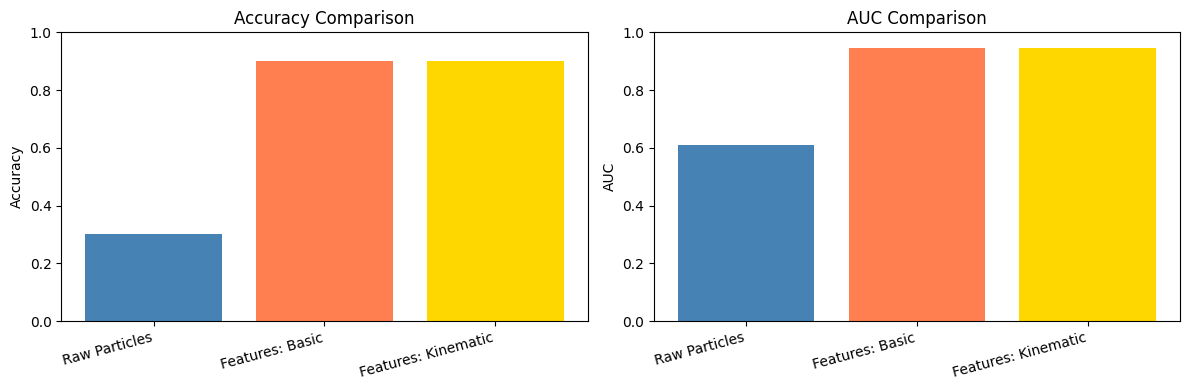


✓ Feature extraction demo complete!


In [ ]:
# Summary
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
for name, res in results.items():
    print(f"{name:25s}: Acc={res['accuracy']:.3f}, AUC={res['auc']:.3f}, Cost=${res['cost']:.4f}")

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

names = list(results.keys())
accs = [results[n]['accuracy'] for n in names]
aucs = [results[n]['auc'] for n in names]

colors = ['steelblue', 'coral', 'gold', 'mediumseagreen', 'orchid']

ax[0].bar(names, accs, color=colors[:len(names)])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy Comparison')
ax[0].set_ylim([0, 1])
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=30, ha='right')

ax[1].bar(names, aucs, color=colors[:len(names)])
ax[1].set_ylabel('AUC')
ax[1].set_title('AUC Comparison')
ax[1].set_ylim([0, 1])
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

print("\n✓ Feature extraction demo complete!")
